# LLMSの応用：Langchainの基礎

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/lvzeyu/css_nlp/blob/master/notebook/langchain_basic.ipynb)

[LangChain](https://www.langchain.com/)は大規模言語モデルを活用したアプリケーション開発を支えるフレームワークです。具体的にはプロンプト設計、RAGインデックス構築、会話メモリ、外部ツール連携、自律エージェントなどLLMアプリに必要な一連の機能を統合的に提供します。これにより、実験段階のプロトタイプから実運用を想定したシステムまで、開発を効率化しやすくなります。

- ```llms```: 言語モデルを呼び出すためのラッパーを提供します
- ```prompts```: プロンプトのテンプレートを作成する機能を提供します
- ```chains```: ひとつのワークフロー内で LLM やプロンプトテンプレートを組み合わせて使用するための機能を提供します
- ```agents```: エージェントを使用することで、課題の解決順序をも LLM を用いて決定し、実行させることができます
- ```memory```: チェーンとエージェントに状態を持たせるための機能を提供します

In [8]:
!pip install -U langchain
!pip install langchain-community
!pip install langchain-core
!pip install langsmith
!pip install openai
!pip install python-dotenv
!pip install -U langchain-openai
!pip install -U langchain-google-genai pillow
!pip install google-generativeai
!pip install google-search-results numexpr wikipedia langchain-experimental

!pip install duckduckgo-search

  Using cached langgraph_checkpoint-4.0.0-py3-none-any.whl.metadata (4.9 kB)
  Using cached langgraph_sdk-0.3.3-py3-none-any.whl.metadata (1.6 kB)
Using cached langgraph_checkpoint-4.0.0-py3-none-any.whl (46 kB)
Using cached langgraph_sdk-0.3.3-py3-none-any.whl (67 kB)
  Attempting uninstall: langchain
    Found existing installation: langchain 0.1.12
    Uninstalling langchain-0.1.12:
      Successfully uninstalled langchain-0.1.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [langchain]/6 [langchain]


## LangChainでLLMを使う


LLMは、ほとんどの生成AIアプリケーションを駆動する原動力である。LangChainは、あらゆるLLM APIプロバイダーとやり取りするためのシンプルなインターフェースを2種類提供している。

- チャットモデルインターフェース: チャットモデルインターフェースを使用すると、ユーザーとモデルの間で双方向の対話を行える
- LLMインターフェース: LLMインターフェースは、文字列プロンプトを入力として受け取り、それをモデルプロバイダーへ送信し、予測結果を出力として返すだけである。


[OpenAI](https://openai.com/blog/openai-api)と[Google(Gemini)](https://deepmind.google/technologies/gemini/#introduction)が提供するAPIを通じて、多岐にわたるAIモデルへのアクセスを可能になります。

APIを使うためには、まず「自分がサービスを利用できる証」となる「APIキー」を発行する必要があります。そして、OpenAIのAPIは、このAPIキーによって利用した使用量に応じて、課金される仕組みです。

そのため、APIキーが外部に漏れると、他者によって不正に使用されて料金が発生してしまうため、他の人へ共有しないように注意しましょう。

LangChainは、さまざまな LLM に汎用インターフェースを提供し、ユーザーがAPIを介してさまざまなモデルを操作できるようにします。

### OpenAI API

`OpenAI`クラスのインスタンスでGPT-3モデルを使用するための設定を行っています。

- `model_name`という引数で、使用する[モデルの名前](https://platform.openai.com/docs/models)を指定します。


- `temperature`という引数は、生成されるテキストのランダム性を制御します。`temperature`が高いほど（1に近いほど）、出力はよりランダムになります。逆に、`temperature`が低いほど（0に近いほど）、モデルの出力はより一貫性があり、予測可能になります。

- `max_tokens`という引数は、生成するテキストの最大トークン数を指定します。この場合、生成されるテキストは最大で256トークンになります。トークンとは、テキストを分割した単位のことで、一般的には単語や句読点などが1トークンとなります。


In [1]:
from dotenv import load_dotenv
import os
import getpass
from langchain_openai import OpenAI, ChatOpenAI     

load_dotenv(dotenv_path='../.env')
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

/home/lvzeyu/anaconda3/envs/jupyterbook/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
llm = OpenAI(
    model="gpt-3.5-turbo-instruct",
    temperature=0.9,
    max_tokens=512
)

In [3]:
llm.invoke("東北大学を紹介してください：")

'\n\n東北大学は、東北地方を代表する総合大学として、1886年に創立されました。学生数は約18,000人で、幅広い学部・大学院・専門学校があり、豊富な教育研究内容を提供しています。\n\n東北大学は研究力が非常に高く、全72学科のうち、70学科が国際水準の研究力を持つ世界トップクラスの大学であり、多くのノーベル賞受賞者を輩出しています。\n\nまた、東北大学は地域社会への貢献も積極的に行っており、被災地支援や地域産業の振興、国際交流など、地域との繋がりを大切にしています。\n\nさらに、東北大学は環境に配慮した取り組みに力を入れており、エコキャンパスとしても知られています。学生が主体となって行うさまざまな活動や取り組みが行われており、環境意識の高い学生が多いことも特徴の一つです。\n\nさまざまな学部・研究分野が揃っているため、学生は様々な分野で学ぶことができ、また研究者としての基礎知識を身につけることができます。また、交流の機会も多く、国内外の学生や研究者との交流を通じて異文化理解を深めることができます。\n\n東北大学は常に時代のニーズに応え'

チャットモデルインターフェースを使用すると、ユーザーとモデルの間で双方向の対話を行える。これが別のインターフェースとして用意されている理由は、OpenAIのような主要LLMプロバイダーが、送受信されるメッセージを「ユーザー」「アシスタント」「システム」というロールに分けて扱っているためである.

ここでのロールとは、メッセージに含まれるコンテンツの種類を示す）。

- システム（system）」ロール: モデルに与える指示を記述する。
- ユーザー（user）ロール: ユーザーのクエリおよびユーザーが生成したコンテンツを表す。
- アシスタント（assistant）ロール: モデルが生成したコンテンツを表す。

In [15]:
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage

model = ChatOpenAI()
prompt = [HumanMessage("東北大学を紹介してください")]

model.invoke(prompt)


AIMessage(content='東北大学は日本の宮城県仙台市に位置する国立大学で、学術研究を重視した総合大学として知られています。創立は1907年で、現在では9学部、15大学院を擁しており、様々な分野での高度な研究成果を上げています。\n\n東北大学は、特に理工学、医学、農学、法学、経済学の分野で高い評価を受けており、多くの優れた研究者や学生が在籍しています。また、東北大学は国内外の大学との交流を大切にし、国際的な研究活動や教育プログラムも積極的に展開しています。\n\n東北大学のキャンパスは豊かな自然に囲まれており、学生の学びや研究活動をサポートする環境が整っています。また、多彩な学生サポート制度や施設も充実しており、学生が充実した大学生活を送れるよう配慮されています。\n\n東北大学は、その歴史と伝統に裏打ちされた高い学術水準と国際展望を持ち、日本を代表する総合大学の一つとして知られています。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 414, 'prompt_tokens': 18, 'total_tokens': 432, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D2aXW78LHTc6jTzTwDC37T5v2t44l', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bfefb-fd95-7de2-ac

In [16]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai.chat_models import ChatOpenAI

model = ChatOpenAI()         
system_msg = SystemMessage(
    '''You are a helpful assistant that responds to questions with three exclamation marks.'''
)# あなたは優秀なアシスタントです。質問に対して3つの感嘆符を付けて回答してください。

human_msg = HumanMessage("東北大学を紹介してください")
model.invoke([system_msg, human_msg])


AIMessage(content='東北大学は日本の仙台市にある大学です！！！優れた教育と研究施設を備えており、世界的にも高い評価を受けています！！！多彩な学部やプログラムがあり、学生たちに豊かな学びと研究の機会を提供しています！！！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 112, 'prompt_tokens': 37, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D2aXbDQr0gagHNUyCbo8r9ZDNh9kf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bfefc-1125-72d2-9119-08e98e4c1487-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 37, 'output_tokens': 112, 'total_tokens': 149, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### Gemini API

#### Gemini APIの設定


In [4]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your GOOGLE API key: ")

In [5]:
import google.generativeai as genai
models = [m for m in genai.list_models()]
models

/home/lvzeyu/anaconda3/envs/jupyterbook/lib/python3.10/site-packages/google/api_core/_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
/tmp/ipykernel_228136/3039597036.py:1: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


[Model(name='models/embedding-gecko-001',
       base_model_id='',
       version='001',
       display_name='Embedding Gecko',
       description='Obtain a distributed representation of a text.',
       input_token_limit=1024,
       output_token_limit=1,
       supported_generation_methods=['embedText', 'countTextTokens'],
       temperature=None,
       max_temperature=None,
       top_p=None,
       top_k=None),
 Model(name='models/gemini-2.5-flash',
       base_model_id='',
       version='001',
       display_name='Gemini 2.5 Flash',
       description=('Stable version of Gemini 2.5 Flash, our mid-size multimodal model that '
                    'supports up to 1 million tokens, released in June of 2025.'),
       input_token_limit=1048576,
       output_token_limit=65536,
       supported_generation_methods=['generateContent',
                                     'countTokens',
                                     'createCachedContent',
                                     'batc

In [6]:
import google.generativeai as genai

llm = genai.GenerativeModel('models/gemini-2.5-flash')

In [7]:
response = llm.generate_content("東北大学を紹介してください：")

In [8]:
response.text

'東北大学は、日本を代表する国立大学の一つであり、その革新的な教育研究、卓越した学術成果、そして地域社会への貢献で高く評価されています。\n\n以下に東北大学の主な特徴を紹介します。\n\n---\n\n### 東北大学の紹介\n\n1.  **設立と歴史：日本で3番目の帝国大学**\n    *   1907年（明治40年）に、東京、京都に次ぐ3番目の帝国大学として設立されました。\n    *   設立当初から「研究第一主義」「門戸開放」「実学尊重」という三つの基本理念を掲げ、日本の高等教育において先駆的な役割を果たしてきました。特に「門戸開放」は画期的で、日本で初めて女子学生と専門学校卒業生を受け入れた帝国大学として知られています。\n\n2.  **基本理念：革新と多様性の追求**\n    *   **研究第一主義 (Research First):** 世界トップレベルの研究を推進し、学術の発展に貢献することを最優先しています。\n    *   **門戸開放 (Open Door):** 性別や出身を問わず、多様な人材を受け入れ、教育機会を提供することを目指しています。これは、現代のダイバーシティ＆インクルージョンに通じる考え方です。\n    *   **実学尊重 (Emphasis on Practical Research):** 理論的な研究だけでなく、その成果を社会に応用し、人類の福祉に貢献することを重視しています。\n\n3.  **学術分野と研究力：世界有数の研究拠点**\n    *   10学部と15研究科（大学院）を擁し、人文科学、社会科学、自然科学、工学、医学、農学など、あらゆる分野を網羅する総合大学です。\n    *   特に**材料科学、スピントロニクス、災害科学、ロボティクス、医工学**などの分野では、世界トップレベルの研究を展開しており、多くの世界的な研究センターを抱えています。\n    *   常に世界の大学ランキング上位に位置し、多くのノーベル賞級の研究者を輩出しています。\n\n4.  **国際性と多様性**\n    *   「門戸開放」の精神は現在も息づいており、多くの留学生が世界各国から集まり、国際色豊かなキャンパスを形成しています。\n    *   英語による講義プログラムも充実しており、グローバルな視

## LLMプロンプトを再利用する: Prompt Templates

プロンプトがモデルの出力に大きく影響することを示した。プロンプトはモデルに文脈を理解させ、クエリに対する適切な回答を生成させる助けとなります。

プロンプトは一見単なる文字列であるが、どのような内容を含めるべきか、またユーザー入力に応じてどのように変化させるべきかを設計するのは容易ではない。

プロンプトテンプレートは、プロンプトを作成する再現可能な方法を指します。これには、エンドユーザーから一連のパラメーターを受け取り、プロンプトを生成するテキスト文字列(テンプレート)が含まれます。

テンプレートは動的パラメータを挿入する位置の定義することで、静的かつ具体的なプロンプトを生成するレシピとして利用できます。

In [9]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    input_variables=["language","text"],
    template="次の日本語のテキストを{language}に翻訳してください：{text}",
)


In [10]:
print(prompt.format(language="英語", text="東北大学は日本の東北地方にある大学です。"))

次の日本語のテキストを英語に翻訳してください：東北大学は日本の東北地方にある大学です。


## チェーン

### チェーンの基本

LLM は単独でも十分に強力に機能します。 しかし、 LLM 同士を組合わせたり、ある機能に特化した他のモジュールとともに利用することで、より複雑なアプリケーションを構築することができます。 LangChain では、このような他の機能と連結するための汎用的なインターフェースとして、チェーンを提供しています。 チェーンを用いることで、LLM の利用を含む "一連の処理" を一つのまとまりとして扱うことができます。

つまり、平易な言葉でいえば、チェーンは「複数の処理の連なり」です。 この処理の連鎖の部品となるチェーンの構成要素のことを リンク と呼びます。 リンクの一例は、LLM の呼び出しなどの基本的な処理です。さらには、その他のチェーン全体をリンクとして含むチェーンも作成できます。

チェーンの代表例は、LLM とプロンプトテンプレートを組合わせて使用するための```LLMChain```です。 このチェーンを用いると、

- ユーザーの入力を受け取り
- それをPromptTemplateでフォーマットし
- フォーマットされたレスポンスを LLM に渡す

という一連の操作を一つのまとまりとして実行できます。 

基本的な使い方としては、LLM や プロンプトテンプレートなどの基本要素を組み合わせて使用することが考えられます。

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="models/gemini-2.5-flash", google_api_key=os.getenv("GOOGLE_API_KEY"))


In [12]:
chain = prompt | llm
chain.invoke(
    {"language":"英語", "text":"東北大学は日本の東北地方にある大学です。"}
)

AIMessage(content="Here's the English translation:\n\nTohoku University is a university in the Tohoku region of Japan.", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bfefd-64d6-76b0-a144-9a59481ca272-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 21, 'output_tokens': 65, 'total_tokens': 86, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 43}})

In [13]:
chain.invoke({"language":"中国語", "text":"東北大学は日本の東北地方にある大学です。"})

AIMessage(content='東北大学是位于日本东北地区的一所大学。', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bfefd-839e-7973-ab08-f1ed03ec6ae1-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 22, 'output_tokens': 619, 'total_tokens': 641, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 608}})

### 実装例:Few Shot Learning

In [14]:
from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate


In [15]:
examples = [
    {"word": "楽しい", "antonym": "悲しい"},
    {"word": "高い", "antonym": "低い"},
]

In [16]:
example_formatter_template = """
Word: {word}
Antonym: {antonym}\n
"""

example_prompt = PromptTemplate(
    input_variables=["word", "antonym"],
    template=example_formatter_template,
)


- `examples`: モデルに示す例を指定します。
- `example_prompt`: 例をどのように提示するかを指定します。
- `prefix`: プロンプトの前置詞を指定します。一般的には、モデルにタスクを説明するためのものです。
- `suffix`: プロンプトの後置詞を指定します。一般的には、モデルに入力と出力の形式を示すためのものです。
- `input_variables`: 入力の変数名を指定します。
- `example_separator`: 例を区切るための文字列を指定します。

In [17]:
few_shot_prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix="Give the antonym of every input",
    suffix="Word: {input}\nAntonym:",
    input_variables=["input"],
    example_separator="\n",
)

In [ ]:
print(few_shot_prompt.format(input="大きい"))

Give the antonym of every input

Word: 楽しい
Antonym: 悲しい



Word: 高い
Antonym: 低い


Word: 大きい
Antonym:


In [ ]:
llm = ChatGoogleGenerativeAI(model="models/gemini-2.5-flash", google_api_key=os.getenv("GOOGLE_API_KEY"))


In [22]:
from langchain_core.output_parsers import StrOutputParser

chain = few_shot_prompt | llm | StrOutputParser()

var = few_shot_prompt.input_variables[0] 
print(chain.invoke({var: "大きい"}))

小さい


#### 課題

Few Shot Learningでセンチメント分析を実装しなさい。

- データフレームから一部のテキストとラベル($n=5$)を抽出し、`examples`を作成します
- Few Shot Learningためのpromptを作成します
- chainを作成し、テストデータから任意のテキストに対するセンチメント予測結果を確認します

In [23]:
#!pip install datasets
from datasets import load_dataset
dataset = load_dataset("imdb")

Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /home/lvzeyu/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Tue Jan 20 15:36:54 2026).


In [24]:
df_train_sample = dataset["train"].to_pandas().sample(5, random_state = 123)
df_test_sample = dataset["test"].to_pandas().sample(5, random_state = 123)

In [25]:
df_train_sample

,text,label
20000,After reading some quite negative views for th...,1
5515,Really no reason to examine this much further ...,0
966,"""Happy Go Lovely"" has only two things going fo...",0
22726,This movie is the first of Miikes triad societ...,1
2690,"Normally I would never rent a movie like this,...",0


## エージェント

### Langchainによるエージェントの作成

エージェントは、「与えられた目的を達成するために、自ら考えて行動するAI」を指します。


特に、「言語モデルに渡されたツールを用いて、モデル自体が次にどのようなアクションを取るかを決定、実行、観測し、完了するまで繰り返す機能」を持つLLMエージェントは近年注目されています。

エージェントは言語モデルとプロンプトの力を活用して、特定の目的を達成するための動的に行動のシーケンスを決定し、非常に多様で適応性が高いです。


- ツール呼び出し: LLMが利用できる外部関数（すなわち選択可能なアクション）の一覧をプロンプトに含め、モデルが選択したアクションをどのようなフォーマットで出力に表現すべきかを指示することが望ましい。これがプロンプトでどのように記述されるかは、後ほど説明する。
- CoT: 複雑な問題を連続する小さなステップに分解して順に推論するよう指示することで、LLMが「より適切な判断」を下すことを研究者たちは発見した。通常は「ステップバイステップで考えよ」といった指示を追加するか、質問を複数のステップ／アクションに分割した例を提示する方法が採られる。


In [11]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain_community.agent_toolkits.load_tools import load_tools

# 1. チャットモデルの初期化
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, verbose=True)

# 2. ツールの読み込み
tools = load_tools(["llm-math", "wikipedia"], llm=llm)

# 3. エージェントの作成
agent = create_agent(
    llm,
    tools,
    system_prompt="""You are a helpful assistant with access to math and wikipedia tools.
Use tools when needed to answer questions accurately. Think step-by-step internally before answering."""
)

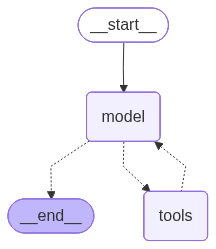

In [4]:
agent

#### wikipedia ツールによる外部情報の検索

In [30]:
# エージェントを使わず、本来のLLMsに回答を出させる場合
llm.invoke("現在の日本の総理大臣は誰ですか？")

AIMessage(content='2021年10月現在、日本の総理大臣は菅義偉（すが よしひで）です。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 27, 'total_tokens': 64, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D2bDZ8wyjtuawZSLhI5PpYUm3PwAa', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bff23-c80d-7982-a8cb-04e8d38124e6-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 27, 'output_tokens': 37, 'total_tokens': 64, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
result = agent.invoke(
    {"messages": [{"role": "user", "content": "現在の日本の総理大臣は誰ですか？"}]}
)

In [6]:
result

{'messages': [HumanMessage(content='現在の日本の総理大臣は誰ですか？', additional_kwargs={}, response_metadata={}, id='0ce1fda4-1436-431a-b904-3681334be319'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 166, 'total_tokens': 184, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D2bLpCDaux4ksq19IIvjx0w1vVcjd', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bff2b-95a6-7380-9d9b-10318d6fb99e-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'List of Prime Ministers of Japan'}, 'id': 'call_Xt3Hf2Lwfe7ehTxxZKM8Jjav', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 166, 'outpu

#### llm-math ツールによる数学演算

In [14]:
225.555*222.555

50198.393025000005

In [15]:
llm.invoke("225.555*222.555=")

AIMessage(content='50,228.332025', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 15, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D2bJ1JnveJgHrAnPugrjK4NQIRM7T', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bff28-edf9-71f3-b562-0e241b89b94c-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 15, 'output_tokens': 6, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
result = agent.invoke(
    {"messages": [{"role": "user", "content": "225.555*222.555="}]}
)

In [ ]:
result

{'messages': [HumanMessage(content='225.555*222.555=', additional_kwargs={}, response_metadata={}, id='50b4d5fb-60c7-45a2-8640-e44dc613e532'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 146, 'total_tokens': 169, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D2bHg53dcDKhvVCloNuMMdlI0QwKh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bff27-ab72-7641-a3be-cb3be33e610b-0', tool_calls=[{'name': 'Calculator', 'args': {'__arg1': '225.555*222.555'}, 'id': 'call_WMYVgliR4Bc0q27FZCnnEkOR', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 146, 'output_tokens': 23, 

### LangChain Hub

[LangChain Hub](https://smith.langchain.com/hub)にはLLMアプリを作成するため多様なPromptTemplateが共有されています。

In [2]:
from langsmith import Client
from langchain_openai import ChatOpenAI

client = Client()

# 自分のプロンプト（例）
prompt = client.pull_prompt("hardkothari/blog-generator")
model = ChatOpenAI(model="gpt-4o-mini")
chain = prompt | model

In [3]:
prompt

ChatPromptTemplate(input_variables=['target_audience', 'text'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'hardkothari', 'lc_hub_repo': 'blog-generator', 'lc_hub_commit_hash': '41ba371c6c1eee9fc5c0d12668accb5fd36036fbd9c3373e5d726ed20db17223'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a blogging expert and a helpful chatbot. '), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['target_audience', 'text'], input_types={}, partial_variables={}, template='Create a well-structured blog post from the provided Context. \n\nThe blog post should should effectively capture the key points, insights, and information from the Context.\n\nFocus on maintaining a coherent flow and using proper grammar and language. \n\nIncorporate relevant headings, subheadings, and bullet points to organize the content. \n\nEnsure that the tone of the blog post i

In [5]:
chain.invoke({'target_audience': "初心者",
              "text": "Langchain hubとは何ですか？"})

AIMessage(content='# Langchain Hubとは何か？初心者のためのガイド\n\nテクノロジーが急速に進化する中、特にAIや自然言語処理の分野では新しいツールやフレームワークが続々と登場しています。その中でも「Langchain Hub」という名前を耳にした方も多いのではないでしょうか。ここでは、Langchain Hubの基本的な概念や利用方法について詳しく解説します。\n\n## Langchain Hubの概要\n\nLangchain Hubは、AI開発者やデータサイエンティストが自然言語処理（NLP）アプリケーションを迅速かつ便利に構築するためのプラットフォームです。このハブは、言語モデル（Language Model）の共有や管理を行うためのリポジトリとして機能します。特に以下の特徴が挙げられます。\n\n- **多様なモデルのアクセス**: Langchain Hubでは、さまざまな言語モデルやツールを簡単に利用できます。これにより、開発者は自分のプロジェクトに最適なモデルを選定可能です。\n- **コラボレーションを促進**: ユーザー同士でモデルを共有し、改善点や新しいアイデアを持ち寄ることで、共同作業が促進されます。\n- **カスタマイズ可能**: ユーザーは各モデルを自分のニーズに応じてカスタマイズし、ライブラリを使って自分のアプリケーションに統合することができます。\n\n## Langchain Hubの主要機能\n\n### 1. モデルのカタログ\n\nLangchain Hubには、数多くの事前トレーニングされた言語モデルがデータベースとして整備されています。以下のようなモデルが含まれています。\n\n- **GPT系モデル**: OpenAIのGPTを基にした多様なバージョン。\n- **BERT系モデル**: Googleが開発したBERTを使用したモデル。\n\n### 2. 簡単なインターフェース\n\n初心者でも使いやすいように設計されたインターフェースを提供しています。ドキュメントやチュートリアルも充実しており、学ぶ過程で必要な情報がすぐに手に入ります。\n\n### 3. コミュニティサポート\n\nLangchain Hubは活発なユーザーコミュニティが存在します。フォーラムやSlackグルー